In [1]:
# This allows you to edit.g code in other files) without having to restart the kernel.
%load_ext autoreload 
%autoreload 2
from torch.utils.data import DataLoader
from src.smalldiffusion import Swissroll, TimeInputMLP, ScheduleLogLinear, training_loop, samples
import numpy as np
import matplotlib.pyplot as plt
from animations import animate_diffusion

/home/hepe00001/anaconda3/envs/generative_diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hepe00001/anaconda3/envs/generative_diffusion/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch, filename, save=False):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

    if save:
        # Save the plot to the specified path
        plt.savefig(filename)

    # Display the plot
    plt.show()
    
    # Close the plot to free up memory
    plt.close()

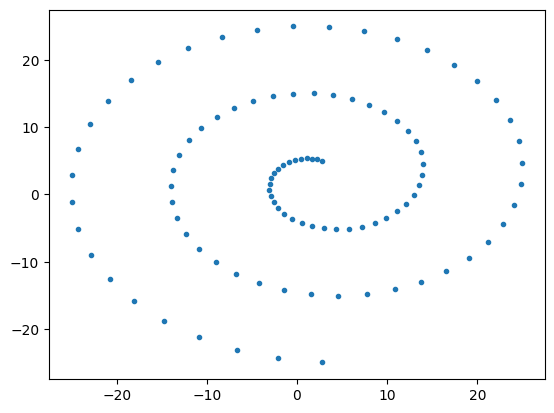

In [14]:
# Define the dataset to be used
# 100 instances and each instance is a 2D tensor
from src.smalldiffusion.data import Swissroll_2


dataset  = Swissroll_2(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2048)

plot_batch(next(iter(loader)), filename="Gauss3", save=False)

In [4]:
# input has 4 dimensions and output has 2 dimensions
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)


TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3093040/2456428996.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma_t$')


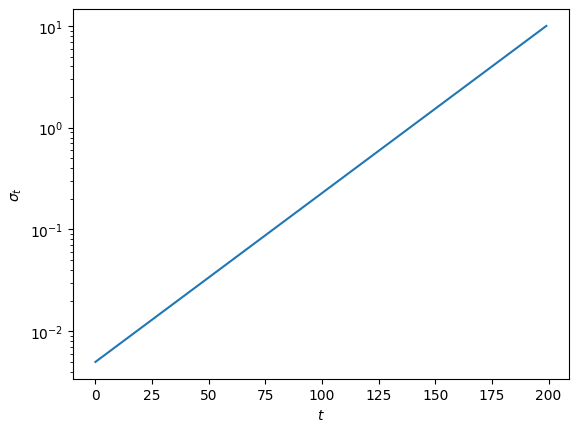

In [5]:
# the sigma values (or variance) in the context of diffusion models typically correspond to 
# the amount of noise added at each time step during the forward diffusion process.
# for this case, the lowest sigma (noise) is 0.005 and there are 200 sigma values
# that will gradually be added during the forward process
schedule = ScheduleLogLinear(N=200, sigma_min=0.005, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$')
plt.yscale('log')

<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3093040/2044932982.py:19: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
/tmp/ipykernel_3093040/2044932982.py:20: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')


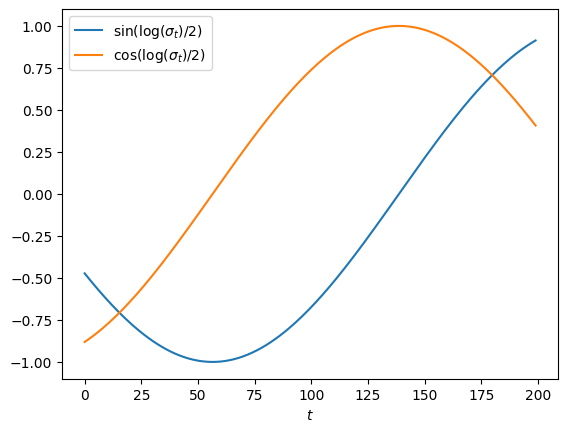

In [6]:
from src.smalldiffusion.model import get_sigma_embeds
"""
Sigma Embeddings
The sigma embeddings transform the sigma values into a form that the model can better utilize. 
This is done using sine and cosine functions of the logarithm of sigma. Here's why this is useful:

Purpose: The goal is to provide the model with a richer representation of the sigma value, 
         which represents the noise level. Instead of directly using sigma, which might 
         have a large dynamic range, the embeddings provide a bounded and periodic representation.

Transformation: By using sine and cosine of the logarithm of sigma, we capture both the scale (logarithm)
                and periodicity (sine and cosine) properties. This can help the model to learn more effectively, 
                especially when sigma varies widely.
"""

# schedule.sigmas is essentially 1D. however, get_sigma_embeds takes it to 2D
# where the first D is "torch.sin(torch.log(sigma)/2)" and the second D is "torch.cos(torch.log(sigma)/2)"
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

In [7]:
trainer  = training_loop(loader, model, schedule, epochs=15000)
losses   = [ns.loss.item() for ns in trainer]

  0%|          | 0/15000 [00:00<?, ?it/s]

sigma tensor([[7.8219e-02],
        [1.0331e-02],
        [1.5556e-01],
        [2.6554e-01],
        [1.3352e-01],
        [1.8829e-01],
        [1.2852e-01],
        [1.4412e-01],
        [1.1031e-01],
        [9.3657e-01],
        [3.9330e-02],
        [5.0282e+00],
        [1.3722e+00],
        [1.5726e-02],
        [8.6769e-01],
        [1.2236e+00],
        [8.2615e+00],
        [1.0503e+00],
        [3.2493e-02],
        [4.5823e-02],
        [1.8626e+00],
        [3.3393e-01],
        [4.3158e+00],
        [1.2370e-01],
        [3.8906e-01],
        [3.3033e+00],
        [7.9519e+00],
        [3.7856e-02],
        [1.2713e+00],
        [1.2236e+00],
        [3.1275e-02],
        [1.2852e-01],
        [7.4475e-01],
        [6.2878e-03],
        [1.8124e-01],
        [3.3758e-02],
        [6.6412e-01],
        [5.3969e-03],
        [1.3208e+00],
        [8.8673e-03],
        [1.5556e-01],
        [4.4105e-02],
        [1.1031e-01],
        [4.1541e+00],
        [2.3679e-01],
    

1


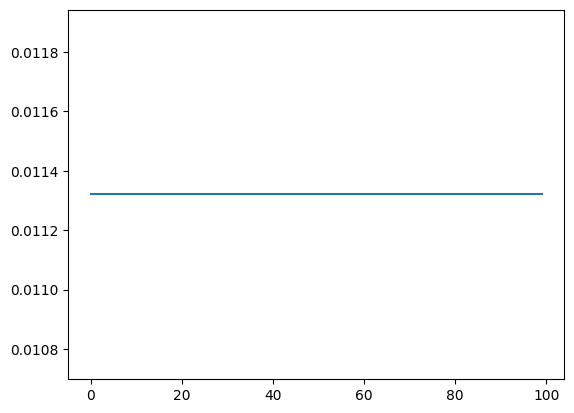

In [8]:
print(len(loader))
# plot the loss
plt.plot(moving_average(losses, 100))
plt.show()

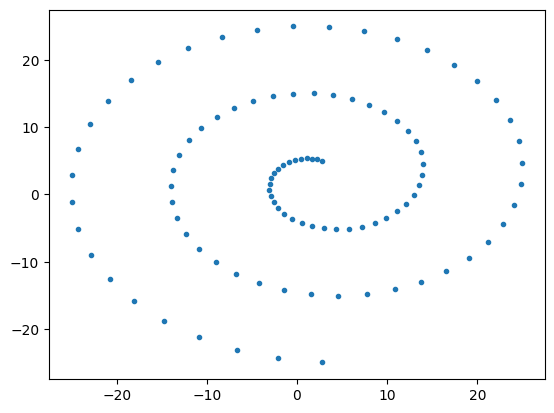

In [9]:
# all the instances in the data combined (plotted) together results
# in this spiral shape. This is essentially the noiseless data that 
# represents the dataset
plot_batch(next(iter(loader)), filename="SR", save=True)

indices [199, 189, 179, 169, 159, 149, 139, 129, 119, 109, 99, 89, 79, 69, 59, 49, 39, 29, 19, 9]
sigmas tensor([1.0000e+01, 6.8253e+00, 4.6584e+00, 3.1795e+00, 2.1701e+00, 1.4811e+00,
        1.0109e+00, 6.8998e-01, 4.7093e-01, 3.2142e-01, 2.1938e-01, 1.4973e-01,
        1.0219e-01, 6.9751e-02, 4.7607e-02, 3.2493e-02, 2.2177e-02, 1.5136e-02,
        1.0331e-02, 7.0512e-03, 5.0000e-03])
sigmas[0] tensor(10.)
xt torch.Size([10, 2])
tensor([[ 19.2692,  14.8728],
        [  9.0072, -21.0552],
        [ -7.5813,  10.7832],
        [  8.0080,  16.8062],
        [  3.5586,  -6.8662],
        [ -4.9336,   2.4149],
        [ -2.3162,   0.4176],
        [ -2.5158,   8.5986],
        [ -3.0973,  -3.9571],
        [  8.0341,  -6.2160]], device='cuda:0')


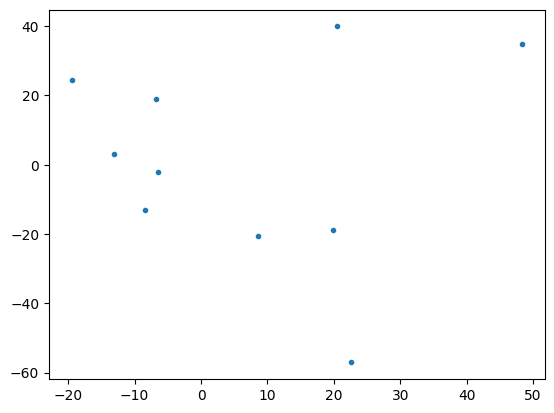

In [10]:
# generate batchsize data points given that amount of initial noise
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
xt = samples(model, schedule.sample_sigmas(20), mu=0.5, batchsize=10)
# convert it to a list
denoising_steps = list(xt)
plot_batch(denoising_steps[9], filename="SR_DDPM_250", save=False)


In [11]:
print(len(denoising_steps[0]))

10


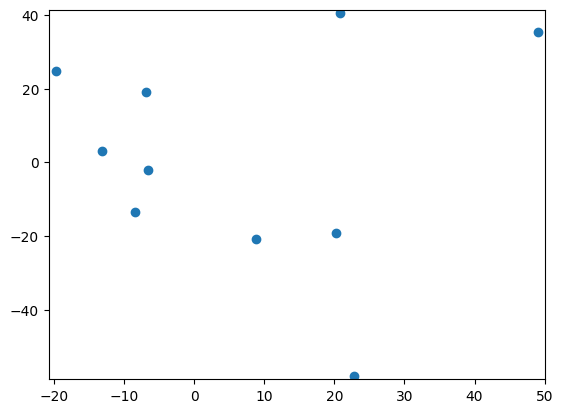

In [12]:
from animations import animate_diffusion_2


animate_diffusion(denoising_steps, filename="SR_DDPM_250", save=False)